In [3]:
import models
import numpy as np
import os
import sys
import config_vmc as cv_module
from numba import jit
from scipy.linalg import schur
from copy import deepcopy

def import_config(filename: str):
    import importlib

    module_name, extension = os.path.splitext(os.path.basename(filename))
    module_dir = os.path.dirname(filename)
    if extension != ".py":
        raise ValueError(
            "Could not import the module from {!r}: not a Python source file.".format(
                filename
            )
        )
    if not os.path.exists(filename):
        raise ValueError(
            "Could not import the module from {!r}: no such file or directory".format(
                filename
            )
        )
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_name)
    sys.path.pop(0)
    return module

@jit(nopython=True)
def get_fft(N, n_bands):
    W = np.zeros((N ** 2, N ** 2), dtype=np.complex128)
    for kx in range(N):
        for ky in range(N):
            for x in range(N):
                for y in range(N):
                    W[x * N + y, kx * N + ky] = np.exp(2.0j * np.pi / N * kx * x + 2.0j * np.pi / N * ky * y)
    return np.kron(W, np.eye(n_bands))
L = 6
config_vmc_file = import_config('./config_vmc.py')
config_vmc_import = config_vmc_file.MC_parameters(L, 0)
config = cv_module.MC_parameters(L, 0)
config.__dict__ = config_vmc_import.__dict__.copy()

@jit(nopython=True)
def fermi(energy, beta):
    return 1 / (1. + np.exp(energy * beta))

[1, 1]
[1, 1]
energy_free_theory =  -0.517342083544613
[-1.07733560e+00 -1.07733560e+00 -1.07733560e+00 -1.07733560e+00
 -1.07733560e+00 -1.07733560e+00 -1.04375261e+00 -1.04375261e+00
 -1.04375261e+00 -1.04375261e+00 -1.04375261e+00 -1.04375261e+00
 -9.93000000e-01 -9.93000000e-01 -7.07734756e-01 -7.07734756e-01
 -7.07734756e-01 -7.07734756e-01 -7.07734756e-01 -7.07734756e-01
 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01
 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01
 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01
 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01
 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01
 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01
 -3.31000000e-01 -3.31000000e-01 -3.31000000e-01 -3.31000000e-01
 -3.31000000e-01 -3.31000000e-01 -1.62991072e-01 -1.62991072e-01
 -1.62991072e-01 -1.62991072e-01 -1.62991072e-01 -1.62991072e-01
 -1.62991072e-01 -1.62991072e-01 -1

In [4]:
Ls = config.Ls
K0 = config.K_0
n_bands = 4
fft = get_fft(Ls, n_bands)


### doing the FFT of K0 ###
K0_fft = fft.conj().T.dot(K0).dot(fft)

K0_check = K0_fft.copy()
for i in range(K0_check.shape[0] // n_bands):
    K0_check[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands] = 0.0
assert np.isclose(np.sum(np.abs(K0_check)), 0.0)

A = np.zeros((L, L, n_bands, n_bands), dtype=np.complex128)
energies = np.zeros((L, L, n_bands), dtype=np.complex128)
for i in range(K0_check.shape[0] // n_bands):
    kx, ky = i % L, i // L
    A[kx, ky, ...] = np.linalg.eigh(K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands])[1]
    energies[kx, ky, ...] = np.linalg.eigh(K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands])[0]

    
@jit(nopython=True)
def get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, temp):
    chi = np.zeros((n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for alpha in range(n_bands):
                for beta in range(n_bands):
                    for p in range(n_bands):
                        for q in range(n_bands):
                            for s in range(n_bands):
                                for t in range(n_bands):
                                    chi[p, q, s, t] -= A[kx, ky, s, alpha] * \
                                               np.conj(A[kx, ky, p, alpha]) * \
                                                       A_plus_q[kx, ky, q, beta] * \
                                               np.conj(A_plus_q[kx, ky, t, beta]) / \
                                                (omega + energies_plus_q[kx, ky, beta] - energies[kx, ky, alpha] + 1e-10j) * \
                                                (fermi(energies_plus_q[kx, ky, beta], temp) - fermi(energies[kx, ky, alpha], temp))
                 
    return chi / n_bands / Ls ** 2 ## FIXME: factor?

susc_0 = np.zeros((L, L, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for qx in range(Ls):
    for qy in range(Ls):
        A_plus_q = np.roll(A, shift = qx, axis=0)
        A_plus_q = np.roll(A_plus_q, shift = qy, axis=1)
    
        energies_plus_q = np.roll(energies, shift = qx, axis=0)
        energies_plus_q = np.roll(energies_plus_q, shift = qy, axis=1)
        susc_0[qx, qy, ...] = get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, 0., 0.1)
susc_uniform = np.sum(susc_0[:, :, np.arange(n_bands), np.arange(n_bands), :, :], axis=2)
susc_uniform = np.sum(susc_uniform[:, :, np.arange(n_bands), np.arange(n_bands)], axis=-1).real

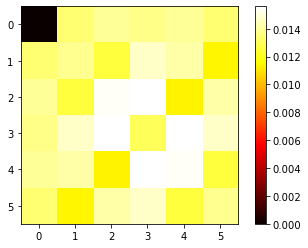

In [14]:
import matplotlib.pyplot as plt
plt.imshow(susc_uniform, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
A = np.array([[1, 0], [1. / 2., np.sqrt(3) / 2.]])
G = 2 * np.pi * np.array([[1, -1. / np.sqrt(3)], [0, 2 / np.sqrt(3)]])

def get_interaction(n_bands, qx, qy, all_distances, vol, U, J):
    U_total = np.zeros((2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)
    q_phys = (G[0] * qx + G[1] * qy) / L
    exp_1 = np.exp(1.0j * np.dot(q_phys, A[0]))
    exp_2 = np.exp(1.0j * np.dot(q_phys, A[1]))

    
    for band in range(4):
        U_total[band, band, band + 4, band + 4] = -U
        U_total[band + 4, band, band + 4, band] = +U
        U_total[band, band + 4, band, band + 4] = +U
        U_total[band + 4, band + 4, band, band] = -U
    
    for subl in range(2):
        for nu in range(2):
            nubar = 1 - nu
            band = subl * 2 + nu
            bandbar = subl * 2 + nubar
            
            for s in range(2):
                for sbar in range(2):
                    U_total[band + 4 * s, band + 4 * s, bandbar + 4 * sbar, bandbar + 4 * sbar] = -U
                    U_total[bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar, band + 4 * s] = +U
                    U_total[band + 4 * s, bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar] = +U
                    U_total[bandbar + 4 * sbar, bandbar + 4 * sbar, band + 4 * s, band + 4 * s] = -U

    US[0, 0, 0, 0] = US[1, 1, 1, 1] = US[2, 2, 2, 2] = US[3, 3, 3, 3] = U
    US[0, 1, 0, 1] = US[1, 0, 1, 0] = US[2, 3, 2, 3] = US[3, 2, 3, 2] = U
    
    

    
    
def get_C_interaction(n_bands, qx, qy, all_distances, vol, U, J):
